In [7]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.solvers.spnia_asym import AsymmetricSPNI
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid
from src.solvers.BendersDecomposition import BendersDecomposition
from data.DataGenerator import DataGenerator

In [ ]:
# Hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = 0.6
B = 5
network = (6, 8)
np.random.seed(31)

# ML hyperparameters
num_features = 5
num_data_samples = 1000

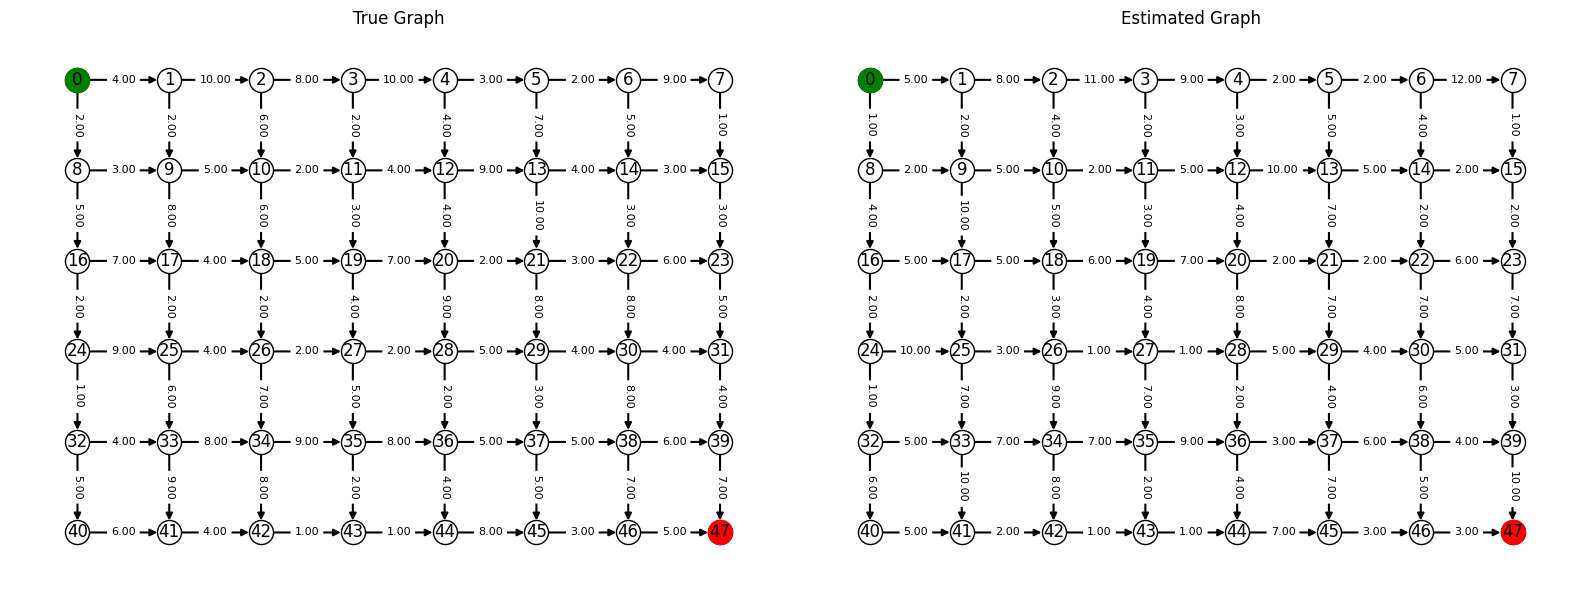

In [ ]:
# Generate true and estimated costs and delays with the formula from Bayrak & Bailey (2008)
true_costs = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (c_max - c_min) + c_min).round(0)
true_delays = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * (d_max - d_min) + d_min).round(0)
# est_costs = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_costs + Q * true_costs).round(0)
# est_delays = (np.random.rand(network[0] * (network[1] - 1) + (network[0] - 1) * network[1]) * 2 * (1 - Q) * true_delays + Q * true_delays).round(0)

# Create the true and estimated graphs
true_graph = ShortestPathGrid(network[0], network[1], true_costs)
# est_graph = ShortestPathGrid(network[0], network[1], est_costs)

# Visualize the the graphs with true and estimated costs
# fig, ax = plt.subplots(1,2,figsize=(16, 6))
# true_graph.visualize(ax=ax[0], title="True Graph")
# est_graph.visualize(ax=ax[1], title="Estimated Graph")
# fig.tight_layout()

In [13]:

data_gen = DataGenerator(
    num_samples=1000,
    num_costs=true_graph.num_cost,
    num_features=num_features,
    c_range=(c_min, c_max),
    epsilon_bar=0.05
)

costs, features = data_gen.generate_data(num_samples=num_data_samples)

NameError: name 'DataGenerator' is not defined